In [1]:
import stat_arb
from stat_arb.model.data_handler import DataHandler
import matplotlib.pyplot as plt
import datetime as dt

plt.style.use("seaborn-v0_8")

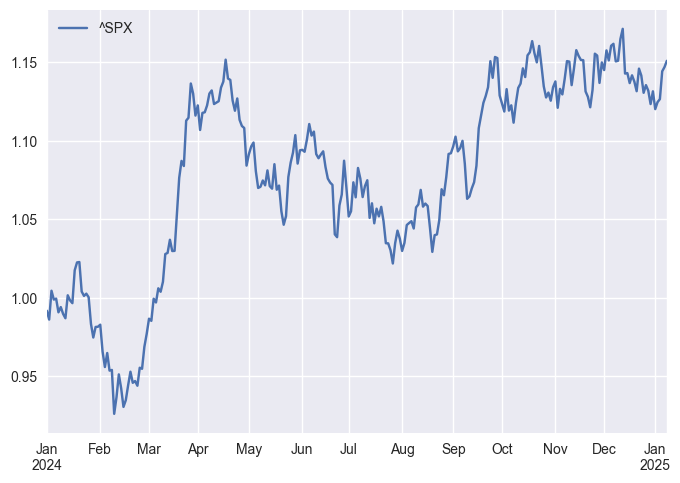

In [2]:
tickers = ["^SPX"]
start = dt.date(2024, 1, 1)
end = dt.date(2025, 1, 8)
live = dt.date(2025, 1, 6)

data = DataHandler(tickers, start, end)

ts = data.get_simulated_close_prices()

ts.plot();